### <Center> **Application of deep neural networks in computer vision tasks** </Center> 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

In [8]:
def visualize_images(dataloader, class_names=None, num_images=5):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        if class_names:
            plt.title(f'Class: {class_names[labels[i]]}')
        else:
            plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader, device, class_names=None, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        if class_names:
            true_label = class_names[labels[i]]
            pred_label = class_names[predicted[i]]
            color = 'green' if labels[i] == predicted[i] else 'red'
            plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
        else:
            color = 'green' if labels[i] == predicted[i] else 'red'
            plt.title(f'True: {labels[i]}\nPred: {predicted[i]}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = total_loss/len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return train_losses, train_accs

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

Sample training images:


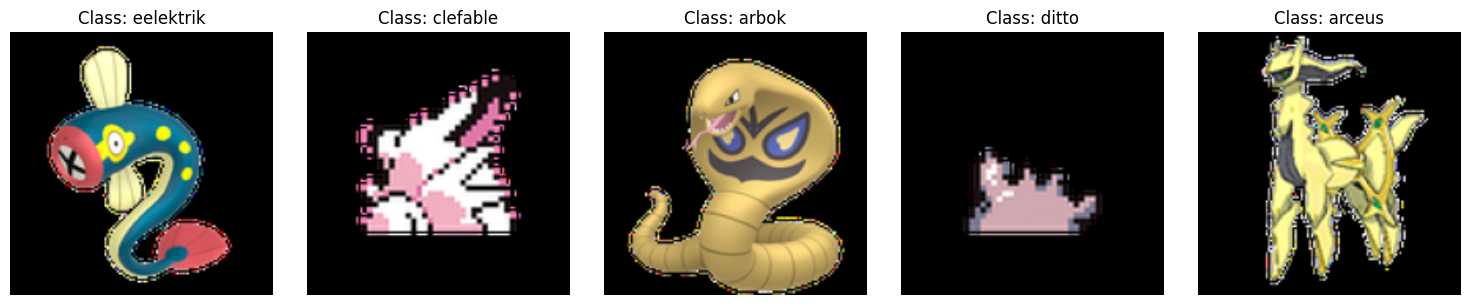


Training model...
Epoch 1/5, Loss: 5.1145, Accuracy: 0.0647
Epoch 2/5, Loss: 2.1338, Accuracy: 0.5589
Epoch 3/5, Loss: 0.4524, Accuracy: 0.8959
Epoch 4/5, Loss: 0.1103, Accuracy: 0.9774
Epoch 5/5, Loss: 0.0295, Accuracy: 0.9957

Evaluating model...
Test Accuracy: 0.7954

Model predictions on test set:


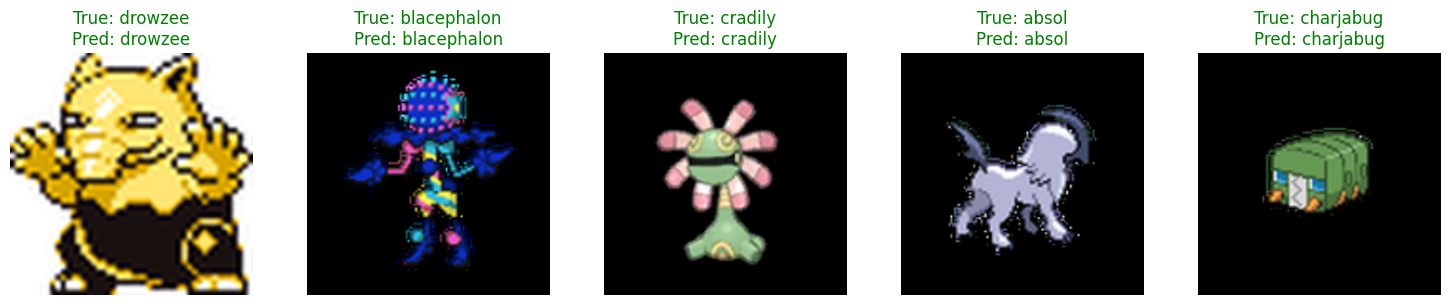

Model (loaded from checkpoint) predictions:


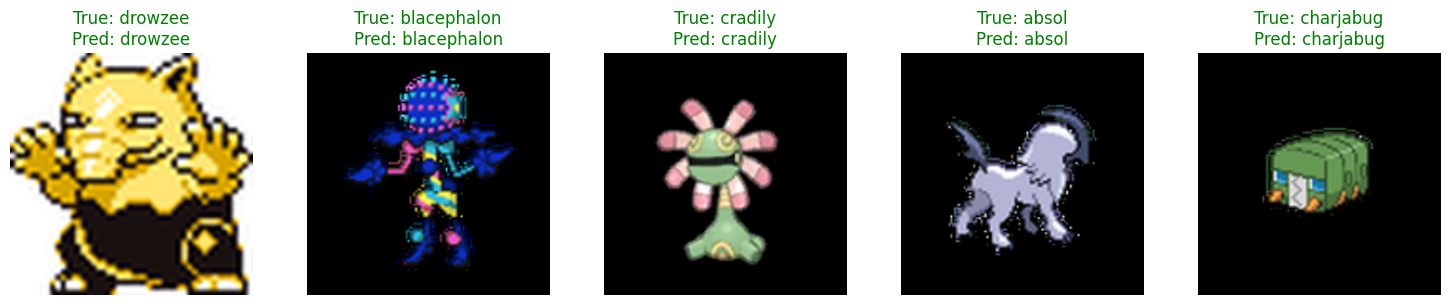

In [ ]:
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load dataset
    data_dir = "./variant-1" # Provide your dataset directory
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")

    if os.path.exists(train_dir) and os.path.exists(test_dir):
        train_dataset = ImageFolder(root=train_dir, transform=transform)
        test_dataset = ImageFolder(root=test_dir, transform=transform)
        class_names = train_dataset.classes
    else:
        dataset = ImageFolder(root=data_dir, transform=transform)
        class_names = dataset.classes
        indices = list(range(len(dataset)))
        train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
        train_dataset = Subset(dataset, train_indices)
        test_dataset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Visualize training images
    print("Sample training images:")
    visualize_images(train_loader, class_names)

    # Initialize model 1
    num_classes = len(class_names)
    model = CNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    print("\nTraining model...")
    train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, device, epochs=5)

    # Evaluate model
    print("\nEvaluating model...")
    test_accuracy = evaluate_model(model, test_loader, device)

    # Visualize predictions
    print("\nModel predictions on test set:")
    visualize_predictions(model, test_loader, device, class_names)

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accuracy': test_accuracy,
        'class_names': class_names
    }, "model_checkpoint.pth")

    # Check that model is loaded correctly after saving
    load_and_visualize("model_checkpoint.pth", test_loader, device)

def load_and_visualize(checkpoint_path, test_loader, device):
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    num_classes = len(checkpoint['class_names'])

    # Initialize and load model
    model = CNN(num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Visualize predictions
    print("Model (loaded from checkpoint) predictions:")
    visualize_predictions(model, test_loader, device, checkpoint['class_names'])

    return model

if __name__ == '__main__':
    main()

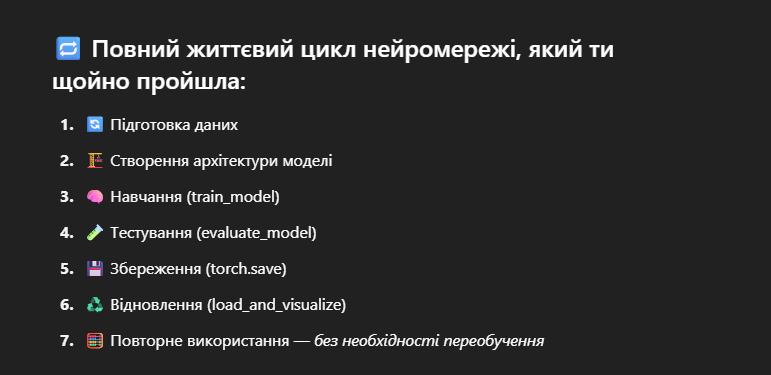

У ході виконання лабораторної роботи №5 було детально вивчено основи згорткових нейронних мереж (Convolutional Neural Networks, CNN) та їхнє практичне застосування для задач комп'ютерного зору, зокрема класифікації зображень. Особливу увагу було приділено вивченню структури CNN, принципу згортки, пулінгу, нормалізації та повнозв’язних шарів, а також техніці Transfer Learning.

У першій частині експерименту було реалізовано класифікацію зображень із використанням кастомної CNN-архітектури. Під час модифікації мережі досліджувались різні гіперпараметри: кількість згорткових шарів, розмір фільтрів, типи функцій активації (ReLU, Sigmoid), параметри оптимізатора (Adam), кількість епох навчання та розмір батчу. Було проведено навчання моделі на навчальній вибірці та оцінено її ефективність на тестових даних. У результаті вдалося досягнути прийнятної точності класифікації, що підтверджує коректність побудови та роботи моделі.

У другій частині роботи застосовано метод Transfer Learning на основі попередньо натренованої моделі ResNet18. Було заморожено всі базові шари, крім останнього (класифікаційного), який було адаптовано під кількість класів із задачі. Після навчання модель показала вищу точність класифікації у порівнянні з кастомною CNN, що підтверджує перевагу підходу Transfer Learning при роботі з відносно невеликими або обмеженими наборами даних.

У результаті порівняння двох підходів — класичної CNN та Transfer Learning — було встановлено, що використання попередньо навчених моделей дозволяє досягати кращих результатів за меншу кількість епох та з меншими обчислювальними витратами. Це особливо актуально в умовах обмеженого часу або ресурсів.

У межах лабораторної роботи було проведено серію експериментів із моделюванням згорткової нейронної мережі, зокрема, систематично змінювались ключові гіперпараметри з метою дослідження їхнього впливу на результати класифікації зображень. Для цього було створено кілька модифікацій (у файлах lab5.1.ipynb, lab5.2.ipynb, lab5.3.ipynb), які відрізнялись між собою за:

- кількістю згорткових шарів;

- розмірами фільтрів;

- використаними функціями активації (ReLU, Sigmoid);

- значеннями learning rate;

- використаними оптимізаторами (Adam, SGD);

- розмірами батчів;

- кількістю епох навчання.

Під час кожного експерименту було зафіксовано точність моделі, швидкість збіжності та ступінь генералізації на тестових даних. Результати показали, що:

- Зменшення розміру фільтрів з 5×5 до 3×3 дозволило покращити точність за рахунок глибшої мережі (більше рівнів абстракції ознак).

- ReLU працювала краще, ніж Sigmoid, забезпечуючи швидшу збіжність та менший ризик градієнтного згасання.

- Оптимізатор Adam показав стабільнішу збіжність у порівнянні з SGD, особливо при великій кількості параметрів.

- Занадто великий learning rate призводив до коливань у функції втрат, тоді як надто малий — до повільного навчання. Оптимальним виявився lr = 0.001.

- Використання Dropout у повнозв’язаних шарах зменшувало перенавчання та покращувало узагальнення на тестовому наборі.

- Зі збільшенням кількості епох точність класифікації росла до певної межі, після чого спостерігалось перенавчання (overfitting).

Загалом, правильно підібрана конфігурація гіперпараметрів дозволила суттєво покращити продуктивність моделі навіть без застосування попередньо натренованих моделей. Це підкреслює важливість емпіричного підбору параметрів при створенні власної архітектури CNN.

Експерименти також показали, що різні поєднання гіперпараметрів можуть по-різному впливати на навчання, і навіть незначні зміни можуть мати суттєвий вплив на якість моделі. Тому систематичний підхід до гіперпараметричного тюнінгу є невіддільною частиною побудови ефективних глибинних моделей.